In [1]:
import pandas as pd
import networkx as nx
import numpy as np

# Read in the CSV files

# 0.1%
#accounts_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230505183351_53313/PS_20230505183351_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_0_1_percent/PS_20230505183351_53313/PS_20230505183351_53313_rawLog.csv")

# 0.5%
accounts_df = pd.read_csv("../datasets/p_0_5_percent/PS_20230509175835_53313/PS_20230509175835_53313_account_attributes.csv")
transactions_df = pd.read_csv("../datasets/p_0_5_percent/PS_20230509175835_53313/PS_20230509175835_53313_rawLog.csv")

# 1%
#accounts_df = pd.read_csv("../datasets/p_1_percent/PS_20230509180228_53313/PS_20230509180228_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_1_percent/PS_20230509180228_53313/PS_20230509180228_53313_rawLog.csv")

# 5%
#accounts_df = pd.read_csv("../datasets/p_5_percent/PS_20230509180753_53313/PS_20230509180753_53313_account_attributes.csv")
#transactions_df = pd.read_csv("../datasets/p_5_percent/PS_20230509180753_53313/PS_20230509180753_53313_rawLog.csv")


In [2]:
import os
import torch
os.environ['TORCH'] = torch.__version__
print(torch.__version__)
# Helper function for visualization.
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
from torch_geometric.transforms import NormalizeFeatures

def visualize(h, color):
    z = TSNE(n_components=2, learning_rate='auto',
             init='random').fit_transform(h.detach().cpu().numpy())

    plt.figure(figsize=(10,10))
    plt.xticks([])
    plt.yticks([])

    plt.scatter(z[:, 0], z[:, 1], s=70, c=color, cmap="Set2")
    plt.show()

def print_model_size(model):
    tot = sum([p.numel() for p in model.parameters() if p.requires_grad])
    out = f"Number of model ({model.__class__.__name__}) parameters:{tot:10d}"
    print("=" * len(out))
    print(out)

2.0.1


In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [4]:
# Implement the In Memory Dataset class

from torch_geometric.data import InMemoryDataset
from torch_geometric.data import Data
from torch.utils.data import random_split

import torch

class FraudDataset(InMemoryDataset):
    def __init__(self, accounts_df, transactions_df, transform=None, pre_transform=None, pre_filter=None):
        super().__init__('.', transform, pre_transform, pre_filter)

        nodes_df = accounts_df
        edges_df = transactions_df
        
        # create dummies for the 'action' column
        dummies = pd.get_dummies(edges_df.action, prefix='action')

        # concatenate the dummies to the original DataFrame
        edges_df = pd.concat([edges_df, dummies], axis=1)

        # drop the original 'action' column
        edges_df.drop('action', axis=1, inplace=True)

        # Now we compute numerical indices for nameOrig and nameDest rather than their form 'CC6839167080'
        # Create a dictionary that maps each unique original name to a new unique ID
        node_ids = {node_name: i for i, node_name in enumerate(set(edges_df['nameOrig']).union(set(edges_df['nameDest'])))}

        # Replace the original names with the new IDs
        edges_df['nameOrig'] = edges_df['nameOrig'].map(node_ids)
        edges_df['nameDest'] = edges_df['nameDest'].map(node_ids)

        x_np = nodes_df.to_numpy()
        x = x_np[:,0:-3]
        
        # Define your graph
        x = torch.nn.functional.normalize(torch.tensor(x),dim=0).to(torch.float32)  # (n x features)
        edge_index =  torch.stack([torch.tensor(edges_df.nameOrig.to_numpy()),torch.tensor(edges_df.nameDest.to_numpy())],dim=-1).T  # Define your edge index
        edge_attr = torch.nn.functional.normalize(torch.tensor(np.array(edges_df[['amount','oldBalanceOrig', 'newBalanceOrig', 'oldBalanceDest', 'newBalanceDest','isFlaggedFraud','isUnauthorizedOverdraft','action_CASH_IN','action_CASH_OUT','action_DEBIT','action_PAYMENT','action_TRANSFER']].values,dtype='float32')),dim=0) # edge features
        y =  torch.tensor(nodes_df.node_isFraud.to_numpy().astype(int),dtype=torch.long) # target values

        # Bitflip the tensor
        #y = y ^ torch.tensor([1], dtype=torch.uint8).expand_as(y)

        train_size = int(0.6 * len(y))  # 60% of the dataset for training
        val_size = int(0.2 * len(y))    # 20% of the dataset for validation
        test_size = len(y) - train_size - val_size  # Remaining 20% for testing

        train_dataset, val_dataset, test_dataset = random_split(y, [train_size, val_size, test_size])

        # Create masks for train, validation, and test sets
        train_mask = torch.zeros(len(y), dtype=torch.bool)
        val_mask = torch.zeros(len(y), dtype=torch.bool)
        test_mask = torch.zeros(len(y), dtype=torch.bool)

        train_mask[train_dataset.indices] = True
        val_mask[val_dataset.indices] = True
        test_mask[test_dataset.indices] = True

        data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr, y=y,train_mask=train_mask, val_mask=val_mask, test_mask=test_mask)
        self.data, self.slices = self.collate([data])
    
    def _download(self):
        return

    def _process(self):
        return

    def __repr__(self):
        return '{}()'.format(self.__class__.__name__)
    
dataset = FraudDataset(accounts_df, transactions_df)
data = dataset[0]
data.to(device)

Data(x=[58246, 41], edge_index=[2, 3788383], edge_attr=[3788383, 12], y=[58246], train_mask=[58246], val_mask=[58246], test_mask=[58246])

In [5]:
# Gather some statistics about the graph.
print(f'Number of nodes: {data.num_nodes}')
print(f'Number of edges: {data.num_edges}')
print(f'Average node degree: {data.num_edges / data.num_nodes:.2f}')

print('==============================')
print(f'Has isolated nodes: {data.has_isolated_nodes()}')
print(f'Has self-loops: {data.has_self_loops()}')
print(f'Is undirected: {data.is_undirected()}')
print(f'Is weighted: {data.edge_weight is not None}')

print('==============================')
print(f'Number of training nodes: {data.train_mask.sum()}')
print(f'Training node label rate: {int(data.train_mask.sum()) / data.num_nodes:.2f}')

Number of nodes: 58246
Number of edges: 3788383
Average node degree: 65.04
Has isolated nodes: False
Has self-loops: False
Is undirected: False
Is weighted: False
Number of training nodes: 34947
Training node label rate: 0.60


In [6]:
from models.MPNN import GNN_MPNN_Model
from models.SAGE import GNN_SAGE_Model
from models.CONV import GNN_CONV_Model
from torch_geometric.nn import Sequential, GAT, GIN

In [7]:
HIDDEN_SIZE = 16 #@param
NUM_LAYERS = 2 #@param

# dataset_num_features = x.size()[1]
dataset_num_features = data.num_features
dataset_num_classes = 2

# Message Passing Neural Network
model = GNN_MPNN_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GraphSAGE
#model = GNN_SAGE_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# CONV
#model = GNN_CONV_Model(hidden_size=HIDDEN_SIZE, input_size=dataset_num_features, output_size= dataset_num_classes, num_layers=NUM_LAYERS)

# GAT
#model = GAT(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_features)

# GIN
#model = GIN(in_channels=dataset_num_features, hidden_channels=HIDDEN_SIZE, num_layers=NUM_LAYERS, out_channels=dataset_num_features)

model.to(device)
model.eval()

out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

In [8]:
import time
from IPython.display import Javascript  # Restrict height of output cell.
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 100})'''))

criterion = torch.nn.CrossEntropyLoss()
#criterion = CrossEntropyFocalLoss(gamma=2)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01, weight_decay=5e-4)

def train():
      model.train()
      optimizer.zero_grad()
      # We now give as input also the graph connectivity
      out = model(data.x, data.edge_index)
      #print(len(out[data.train_mask]),len(data.y[data.train_mask]))
      loss = criterion(out[data.train_mask], data.y[data.train_mask])
      #loss = sigmoid_focal_loss(out[data.train_mask], data.y[data.train_mask])
      loss.backward()
      optimizer.step()
      return loss

def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

#print("epoch,train_loss,validation_loss")
st = time.time()
for epoch in range(1, 401):
    train_loss = train()
    val_loss, _, _ = test(data.val_mask)
    
    #print(f'Epoch: {epoch:03d} - Training loss: {train_loss:.4f} - ' f'Validation accuracy: {val_loss * 100:.2f}%')
    print(str(epoch) + ',' + str(train_loss.item()) + ',' + str(val_loss*100) + ';')
et = time.time()
elapsed_time = et - st


<IPython.core.display.Javascript object>

1,0.6644265651702881,94.23126448622199;
2,0.6127468347549438,94.23126448622199;
3,0.5682151913642883,94.23126448622199;
4,0.528313398361206,94.23126448622199;
5,0.4903283715248108,94.23126448622199;
6,0.45254629850387573,94.23126448622199;
7,0.4144653081893921,94.23126448622199;
8,0.37654775381088257,94.23126448622199;
9,0.3399432897567749,94.23126448622199;
10,0.3062257468700409,94.23126448622199;
11,0.27707037329673767,94.23126448622199;
12,0.25387042760849,94.23126448622199;
13,0.2373850792646408,94.23126448622199;
14,0.2275434136390686,94.23126448622199;
15,0.22348463535308838,94.23126448622199;
16,0.22381305694580078,94.23126448622199;
17,0.22694750130176544,94.23126448622199;
18,0.23143160343170166,94.23126448622199;
19,0.2361225187778473,94.23126448622199;
20,0.24024462699890137,94.23126448622199;
21,0.24334989488124847,94.23126448622199;
22,0.245241180062294,94.23126448622199;
23,0.24589663743972778,94.23126448622199;
24,0.24540968239307404,94.23126448622199;
25,0.2439462989568

In [9]:
print("Time for", epoch, "epochs is", elapsed_time, "seconds")

Time for 400 epochs is 778.9394528865814 seconds


In [10]:
def test(mask):
      model.eval()
      out = model(data.x, data.edge_index)
      pred = out.argmax(dim=1)
      test_correct = pred[mask] == data.y[mask]
      test_acc = int(test_correct.sum()) / int(mask.sum())
      test_out = out[mask]
      test_pred = pred[mask]
      return test_acc, test_out, test_pred

In [11]:
test_acc, test_out, test_pred  = test(data.test_mask)
print(f'Test Accuracy: {test_acc * 100:.2f}%')

Test Accuracy: 97.71%


In [13]:
out = model(data.x, data.edge_index)
#visualize(out, color=data.y)

tensor(446)
tensor(0.0609)
Precision: 1.00
Recall: 0.63
F1-score: 0.77


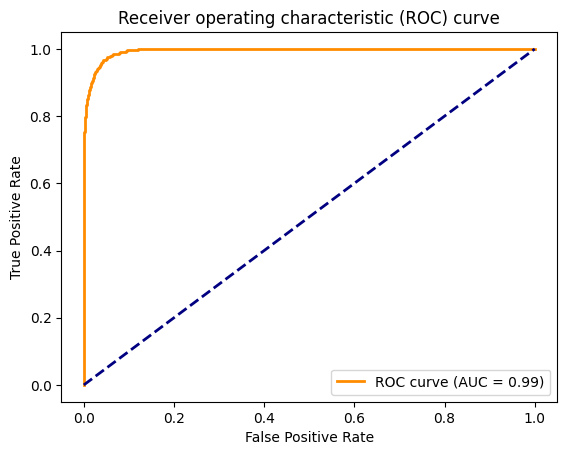

In [14]:
from sklearn.metrics import roc_curve, auc, precision_recall_fscore_support
import torch.nn.functional as F

y_true = data.y[data.test_mask].cpu()
y_pred = softmax_x = F.softmax(test_out, dim=1)
test_pred = y_pred.argmax(dim=1).detach().cpu()
y_pred = y_pred[:, 1].detach().cpu().numpy()
print(torch.sum(test_pred))
print(torch.sum(y_true)/y_true.shape[0])


# Calculate precision, recall, and F1-score
precision, recall, f1_score, _ = precision_recall_fscore_support(y_true, test_pred, average='binary')

print("Precision: {:.2f}".format(precision))
print("Recall: {:.2f}".format(recall))
print("F1-score: {:.2f}".format(f1_score))

# Generate ROC curve
fpr, tpr, thresholds = roc_curve(y_true, y_pred)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()

In [15]:
fpr, tpr, roc_auc

df_model = pd.DataFrame({'fpr': fpr, 'tpr': tpr})
df_model.to_csv('results/_5.csv', index=False)